**BBM479 DATA INTENSIVE LAB - DSCP PROJECT: Decoding Economic Growth**


### **1. Environment Setup & Data Acquisition**

In this section, we mount the Google Drive to access datasets and import necessary libraries. We define the file paths and mapping dictionaries to translate World Bank codes into readable feature names.

In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from google.colab import drive

In [ ]:
# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Configuration
BASE_PATH = "/content/drive/MyDrive/NumPie_DSCP/Datasets"

feature_map = {
    "NY.GDP.MKTP.KD.ZG": "GDP_Growth", "NV.AGR.TOTL.ZS": "Agriculture_GDP", "IT.NET.USER.ZS": "Internet_Users",
    "EG.USE.PCAP.KG.OE": "Energy_Use", "SE.XPD.TOTL.GD.ZS": "Education_Spend", "PV.EST": "Political_Stability",
    "SP.URB.TOTL.IN.ZS": "Urban_Pop", "SI.POV.GINI": "Gini_Index", "SP.POP.TOTL": "Total_Population",
    "SH.DYN.MORT": "Infant_Mortality", "SL.UEM.TOTL.ZS": "Unemployment", "FP.CPI.TOTL.ZG": "Inflation",
    "NE.GDI.TOTL.ZS": "Investment_GDP", "NE.TRD.GNFS.ZS": "Trade_GDP"
}

wb_files = [
    "API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_128624.csv", "API_IT.NET.USER.ZS_DS2_en_csv_v2_129784.csv",
    "API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_130096.csv", "API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_216037.csv",
    "API_PV.EST_DS2_en_csv_v2_126909.csv", "API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_129596.csv",
    "API_SI.POV.GINI_DS2_en_csv_v2_252305.csv", "API_SP.POP.TOTL_DS2_en_csv_v2_246068.csv",
    "API_SH.DYN.MORT_DS2_en_csv_v2_125549.csv", "API_SL.UEM.TOTL.ZS_DS2_en_csv_v2_254884.csv",
    "API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_260128.csv", "API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_268992.csv",
    "API_NE.GDI.TOTL.ZS_DS2_en_csv_v2_122765.csv", "API_NE.TRD.GNFS.ZS_DS2_en_csv_v2_242492.csv"
]

Mounted at /content/drive


### **2. Data Fusion & Processing Pipeline**

Here we implement the "Data Fusion" strategy. We:

* Iterate through raw CSV files.

* Transform data from Wide to Long format.

* Merge 16 datasets into a single panel.

* Integrate Global Financial Data (Gold & USD Index) and Regional Data via ISO codes.

In [ ]:
dataframes = []
print("Starting Data Ingestion...")

# 1. Load World Bank Data
for file in wb_files:
    try:
        folder_name = file.replace(".csv", "")
        file_path = os.path.join(BASE_PATH, folder_name, file)

        if os.path.exists(file_path):
            df_temp = pd.read_csv(file_path, skiprows=4)
            df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
            code = df_temp['Indicator Code'].iloc[0]

            if code in feature_map:
                name = feature_map[code]
                id_vars = ['Country Name', 'Country Code']
                val_vars = [c for c in df_temp.columns if c.isdigit()]

                # Wide -> Long Transformation
                melted = df_temp.melt(id_vars=id_vars, value_vars=val_vars, var_name='Year', value_name='Value')
                melted['Feature'] = name
                melted['Year'] = pd.to_numeric(melted['Year'])
                dataframes.append(melted)
    except Exception as e:
        print(f"Warning: Could not read {file}: {e}")

# 2. Pivot to Create Feature Matrix
if dataframes:
    all_wb = pd.concat(dataframes, ignore_index=True)
    df = all_wb.pivot_table(index=['Country Code', 'Country Name', 'Year'], columns='Feature', values='Value').reset_index()
    print("Base DataFrame Created.")

# 3. Add Regions (ISO Standardization)
try:
    url = "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
    s = requests.get(url).content
    regions = pd.read_csv(io.StringIO(s.decode('utf-8')))
    regions = regions[['alpha-3', 'region']]
    regions.columns = ['Country Code', 'Region']
    df = pd.merge(df, regions, on='Country Code', how='left')
    df = pd.get_dummies(df, columns=['Region'], prefix='Reg', dummy_na=False)
    print("Region Data Merged.")
except Exception as e:
    print(f"Region merge skipped: {e}")

# 4. Add Global Financials (Gold & USD)
try:
    gold = pd.read_csv(os.path.join(BASE_PATH, "year_xau.csv"))
    usd = pd.read_csv(os.path.join(BASE_PATH, "year_usd_index.csv"))

    # Gold Processing
    gold_col = [c for c in gold.columns if 'price' in c.lower() or 'xau' in c.lower()][0]
    gold = gold.rename(columns={gold.columns[0]: 'Year', gold_col: 'Gold_Price'})
    gold['Gold_Pct_Change'] = gold['Gold_Price'].pct_change()

    # USD Processing
    usd_col = [c for c in usd.columns if 'close' in c.lower() or 'index' in c.lower()][0]
    usd = usd.rename(columns={usd.columns[0]: 'Year', usd_col: 'USD_Index'})
    usd['USD_Pct_Change'] = usd['USD_Index'].pct_change()

    df = pd.merge(df, gold[['Year', 'Gold_Pct_Change']], on='Year', how='left')
    df = pd.merge(df, usd[['Year', 'USD_Pct_Change']], on='Year', how='left')
except Exception as e:
    pass

Starting Data Ingestion...
Base DataFrame Created.
Region Data Merged.


### **3. Smart Preprocessing & Feature Engineering**

In this step, we apply "Domain-Aware Preprocessing":

* Logic-Based Imputation: Setting Internet Users to 0 before 1990.

* Interpolation: Filling missing time-series data linearly.

* Outlier Handling: Clipping GDP growth between -30% and +30%.

* Feature Engineering: Creating Lags (t−1,t−2), Rolling Statistics (3-Year Mean/Vol), and Global Interaction terms.

In [ ]:
print("Starting Preprocessing...")

# 1. Target Cleaning
df = df.dropna(subset=['GDP_Growth'])
df['GDP_Growth'] = df['GDP_Growth'].clip(lower=-30, upper=30)

# 2. Logic-Based Imputation
if 'Internet_Users' in df.columns:
    df.loc[df['Year'] < 1990, 'Internet_Users'] = 0

# 3. Time-Series Interpolation
numeric_cols = df.select_dtypes(include=[np.number]).columns
df = df.sort_values(by=['Country Code', 'Year'])
df[numeric_cols] = df.groupby('Country Code')[numeric_cols].transform(
    lambda x: x.interpolate(method='linear').ffill().bfill()
)
df = df.dropna()

# 4. Feature Engineering
if 'Total_Population' in df.columns:
    df['Log_Pop'] = np.log1p(df['Total_Population'])

# Momentum Features
df['GDP_Vol_3Y'] = df.groupby('Country Code')['GDP_Growth'].transform(lambda x: x.rolling(3).std())
df['GDP_MA_3Y'] = df.groupby('Country Code')['GDP_Growth'].transform(lambda x: x.rolling(3).mean())
df['GDP_Lag1'] = df.groupby('Country Code')['GDP_Growth'].shift(1)
df['GDP_Lag2'] = df.groupby('Country Code')['GDP_Growth'].shift(2)

# Global Context Features
df['Lag_World_Mean_GDP'] = df.groupby('Year')['GDP_Growth'].transform('mean').shift(1)

# Interaction Features
if 'Trade_GDP' in df.columns:
    df['Trade_x_World'] = df['Trade_GDP'] * df['Lag_World_Mean_GDP']

# Final Cleanup
df_final = df.dropna()
print(f"Preprocessing Complete. Final Shape: {df_final.shape}")

Starting Preprocessing...
Preprocessing Complete. Final Shape: (7639, 29)


In [ ]:
# Show Clean and Merged Data
df_final.head()

,Country Code,Country Name,Year,Agriculture_GDP,Education_Spend,Energy_Use,GDP_Growth,Gini_Index,Infant_Mortality,Inflation,...,Reg_Asia,Reg_Europe,Reg_Oceania,Log_Pop,GDP_Vol_3Y,GDP_MA_3Y,GDP_Lag1,GDP_Lag2,Lag_World_Mean_GDP,Trade_x_World
283,AGO,Angola,1983,6.653214,4.09022,506.098907,4.200001,51.9,230.0,98.224144,...,False,False,False,16.021913,4.300389,-0.066667,0.000000,-4.400001,1.558581,164.121336
284,AGO,Angola,1984,6.653214,4.09022,506.098907,6.000002,51.9,228.0,98.224144,...,False,False,False,16.058974,3.078962,3.400001,4.200001,0.000000,1.595398,167.998235
285,AGO,Angola,1985,6.653214,4.09022,506.098907,3.499999,51.9,226.3,98.224144,...,False,False,False,16.095760,1.289704,4.566668,6.000002,4.200001,3.200413,337.009066
286,AGO,Angola,1986,6.653214,5.72269,506.098907,2.900002,51.9,225.0,98.224144,...,False,False,False,16.131944,1.644182,4.133334,3.499999,6.000002,3.035043,319.595328
287,AGO,Angola,1987,6.653214,5.05851,506.098907,4.082749,51.9,224.0,98.224144,...,False,False,False,16.166682,0.591394,3.494250,2.900002,3.499999,3.298591,347.347330


### **4. Time-Aware Validation Split**

To prevent data leakage, we strictly separate the past from the future.

* **Training Set:** Data up to 2014.

* **Testing Set:** Data from 2015 to 2023.

In [ ]:
train = df_final[df_final['Year'] <= 2014]
test = df_final[df_final['Year'] > 2014]

drop_cols = ['Country Code', 'Country Name', 'SubRegion', 'GDP_Growth', 'Total_Population']
features = [c for c in df_final.columns if c not in drop_cols and df_final[c].dtype != 'object']

X_train, y_train = train[features], train['GDP_Growth']
X_test, y_test = test[features], test['GDP_Growth']

print(f"Training Set: {X_train.shape} (Years <= 2014)")
print(f"Testing Set:  {X_test.shape} (Years > 2014)")

Training Set: (6233, 25) (Years <= 2014)
Testing Set:  (1406, 25) (Years > 2014)


### **5. Experiment 1: Baseline Model (Random Forest)**

We train a Random Forest Regressor to establish a baseline performance metric.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print("Random Forest Results:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R2:   {rf_r2:.4f}")

Random Forest Results:
RMSE: 1.7517
R2:   0.8724


### **6. Experiment 2: Optimized Model (XGBoost)**

We perform hyperparameter tuning using `RandomizedSearchCV` combined with `TimeSeriesSplit` to respect the chronological order of data.

In [ ]:
print("Starting Hyperparameter Tuning...")

param_dist = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_base = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# Final Predictions
preds = best_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, preds))
xgb_r2 = r2_score(y_test, preds)

print(f"\nBest Params: {search.best_params_}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R2:   {xgb_r2:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost RMSE: 0.9128
XGBoost R2:   0.9654


### **7. Comparative Evaluation**

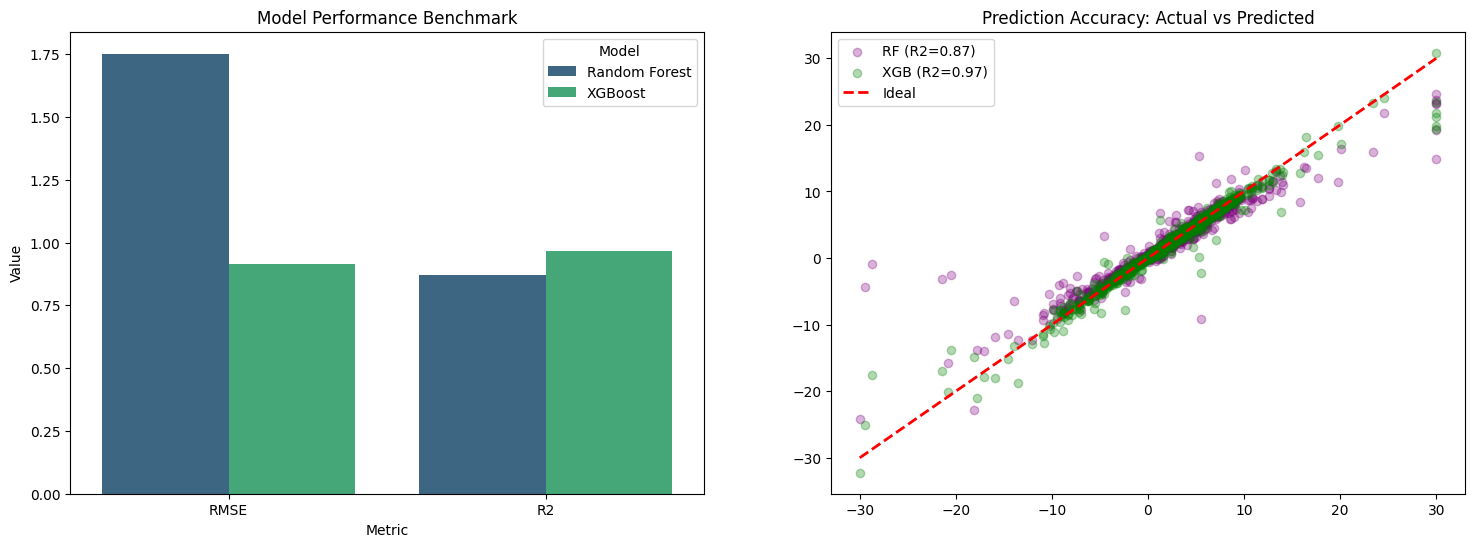

In [ ]:
# Metrics Data
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest', 'XGBoost', 'XGBoost'],
    'Metric': ['RMSE', 'R2', 'RMSE', 'R2'],
    'Value': [rf_rmse, rf_r2, xgb_rmse, xgb_r2]
})

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Bar Chart
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Model', ax=axes[0], palette='viridis')
axes[0].set_title('Model Performance Benchmark')

# 2. Scatter Plot (Actual vs Predicted)
axes[1].scatter(y_test, rf_preds, alpha=0.3, label=f'RF (R2={rf_r2:.2f})', color='purple')
axes[1].scatter(y_test, preds, alpha=0.3, label=f'XGB (R2={xgb_r2:.2f})', color='green')
# Perfect Line
min_val, max_val = y_test.min(), y_test.max()
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

axes[1].set_title('Prediction Accuracy: Actual vs Predicted')
axes[1].legend()
plt.show()

### **8. Explainability: SHAP Structural Analysis**

We analyze the "Why" behind predictions. We filter out Lag features to focus on Structural Drivers (e.g., Investment, Inflation, Global Context).

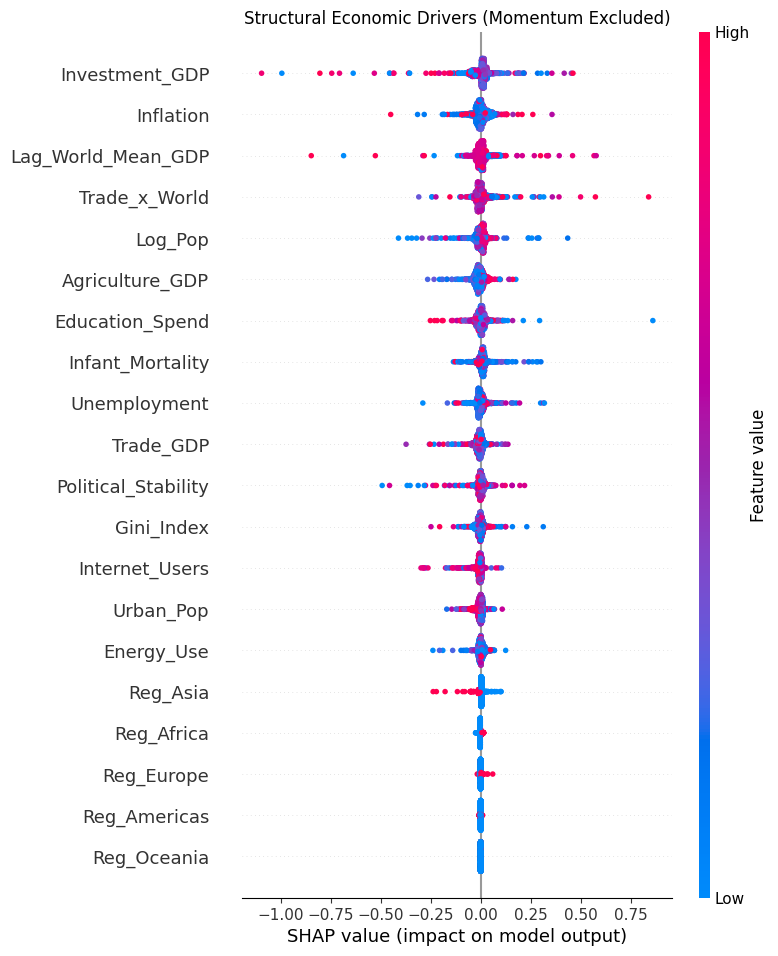

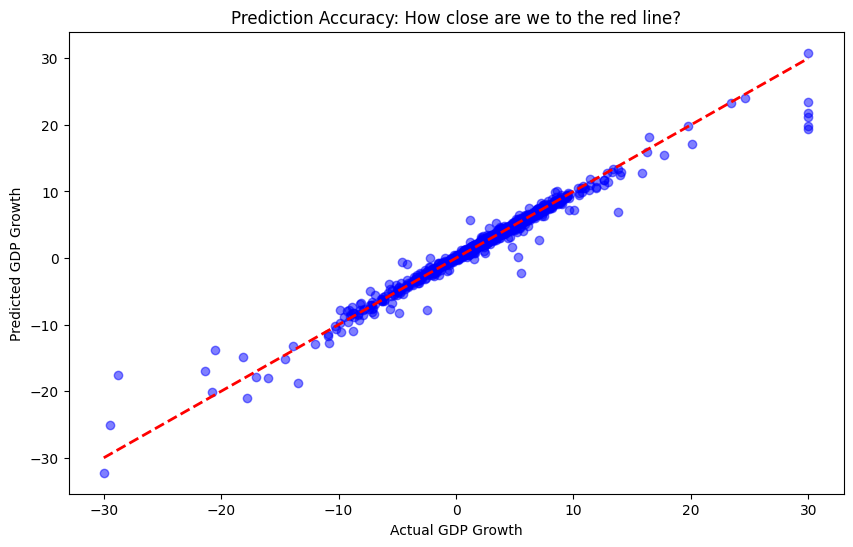

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Filter out Momentum Features to see Structural Drivers
cols_to_exclude = ['Year','GDP_Lag1', 'GDP_Lag2', 'GDP_MA_3Y', 'GDP_Vol_3Y']
structural_cols = [c for c in X_test.columns if c not in cols_to_exclude]

shap_values_filtered = shap_df[structural_cols].values
X_test_filtered = X_test[structural_cols]


# Plot 1: Economic Drivers
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_filtered, X_test_filtered, show=False)
plt.title("Structural Economic Drivers (Momentum Excluded)")
plt.show()

# Plot 2: Prediction vs Reality
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual GDP Growth")
plt.ylabel("Predicted GDP Growth")
plt.title("Prediction Accuracy: How close are we to the red line?")
plt.show()

### **9. Temporal Analysis: Driver Evolution**

We examine how the importance of key economic drivers changes over different historical phases (1960-1980, 1981-2000, 2001-2023).


=== Phase Metrics (within-phase temporal split) ===
                Phase  YearRange  Rows TrainYears  TestYears     RMSE  \
0  Phase 1: 1960–1980  1960-1980  1717  1963-1976  1977-1980  3.03726   
1  Phase 2: 1981–2000  1981-2000  2524  1981-1996  1997-2000  1.27691   
2  Phase 3: 2001–2023  2001-2023  3262  2001-2018  2019-2023  2.12348   

         R2  
0  0.765131  
1  0.941444  
2  0.879698  

=== Top 10 Drivers per Phase (Mean(|SHAP|) on phase test set) ===

Phase 1: 1960–1980
           Feature  MeanAbsSHAP
    Investment_GDP     0.108319
Lag_World_Mean_GDP     0.075762
     Trade_x_World     0.057442
           Log_Pop     0.054623
         Trade_GDP     0.045175
      Unemployment     0.042488
         Urban_Pop     0.038508
   Education_Spend     0.037456
   Agriculture_GDP     0.035994
  Infant_Mortality     0.032154

Phase 2: 1981–2000
            Feature  MeanAbsSHAP
      Trade_x_World     0.063755
         Energy_Use     0.050158
     Investment_GDP     0.043421
     In

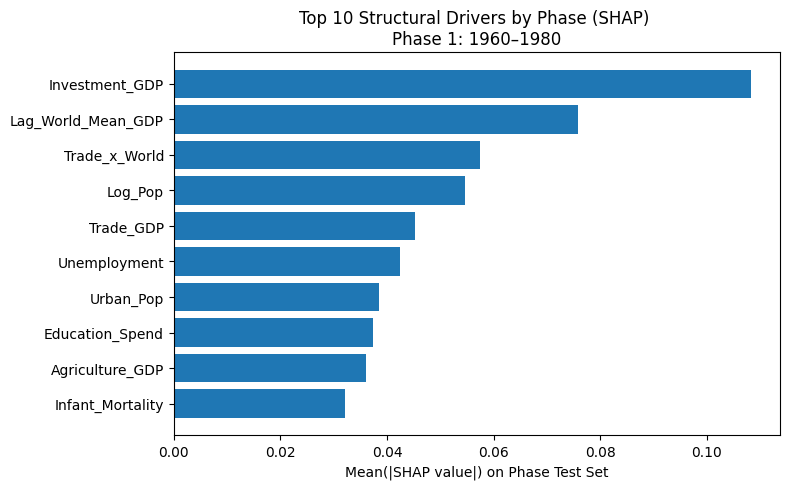

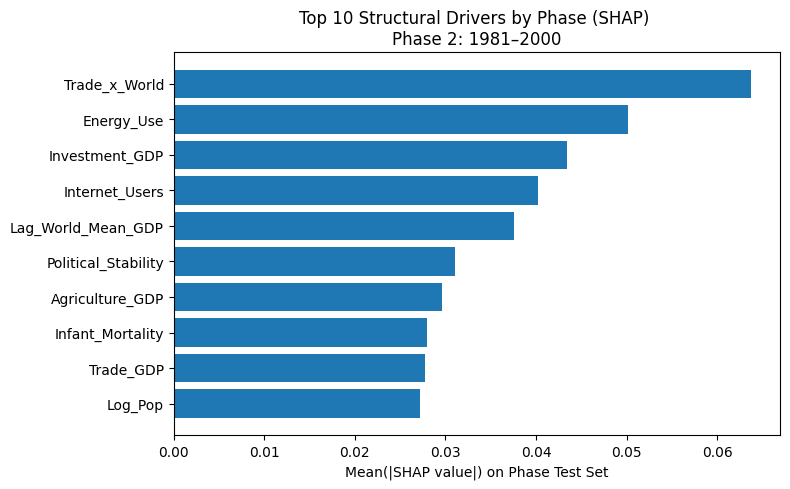

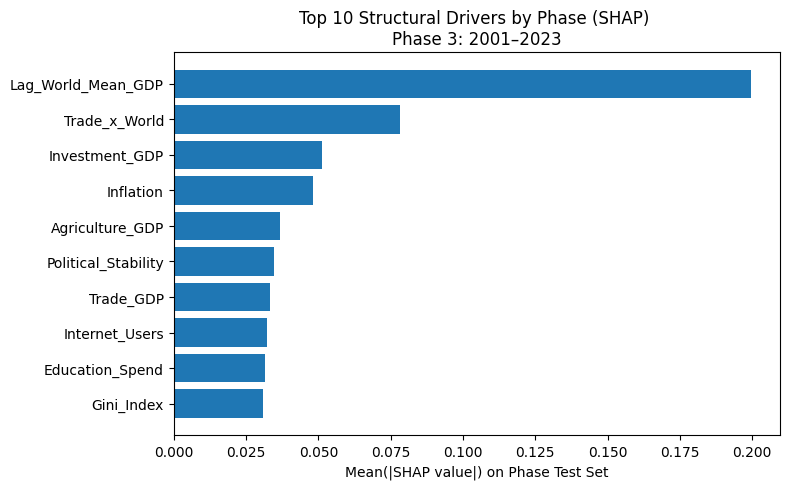

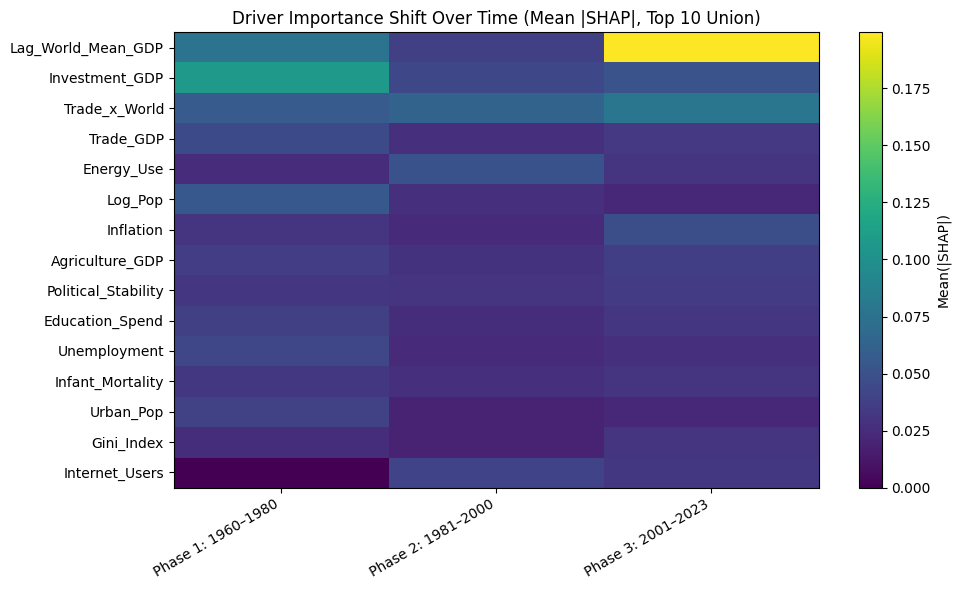

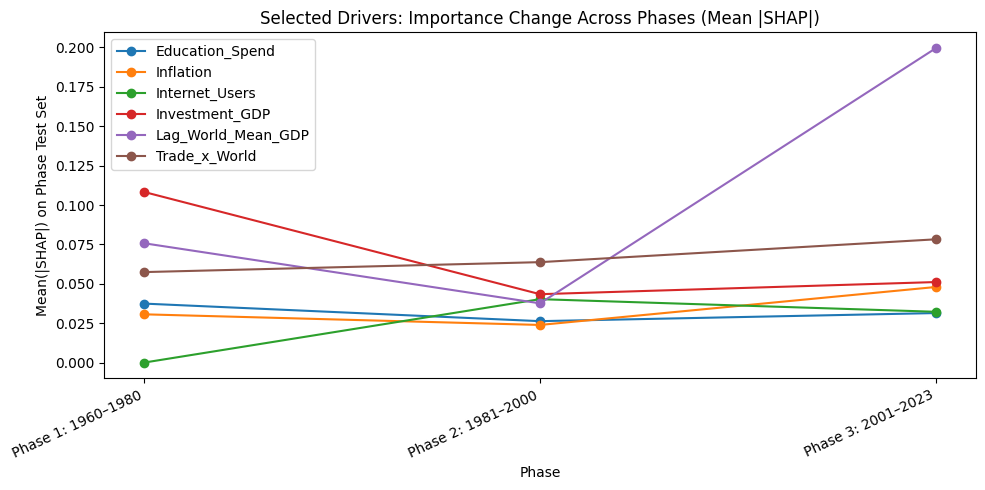

In [ ]:

def train_phase_and_shap_rank(
    df_final: pd.DataFrame,
    features: list,
    phase_name: str,
    year_start: int,
    year_end: int,
    cols_to_exclude=None,
    use_same_best_params=True,
    fixed_best_params=None,
    tune_params=False,
    n_iter=15,
    random_state=42
):
    """
    Trains an XGBoost model on the specified year range and returns:
      - model
      - phase metrics (RMSE, R2 on in-phase time split)
      - SHAP mean(|value|) ranking DataFrame for structural drivers
    Notes:
      - Uses a time-aware split INSIDE the phase:
          train = first 80% years, test = last 20% years
      - SHAP ranking computed on the in-phase test set for comparability.
    """

    if cols_to_exclude is None:
        cols_to_exclude = ['GDP_Lag1', 'GDP_Lag2', 'GDP_MA_3Y', 'GDP_Vol_3Y']

    # Filter phase data
    phase_df = df_final[(df_final['Year'] >= year_start) & (df_final['Year'] <= year_end)].copy()
    phase_df = phase_df.sort_values('Year')

    # Safety check
    if len(phase_df) < 200:
        print(f"[WARN] {phase_name}: Very small sample ({len(phase_df)} rows). "
              f"Consider widening the range or reducing features.")

    X = phase_df[features]
    y = phase_df['GDP_Growth']

    # Time-aware split by YEAR within the phase
    unique_years = np.sort(phase_df['Year'].unique())
    split_point = int(len(unique_years) * 0.8)
    train_years = unique_years[:split_point]
    test_years = unique_years[split_point:]

    train_mask = phase_df['Year'].isin(train_years)
    test_mask = phase_df['Year'].isin(test_years)

    X_train, y_train = X.loc[train_mask], y.loc[train_mask]
    X_test, y_test = X.loc[test_mask], y.loc[test_mask]

    # Build model
    if tune_params:
        # Optional: tune within the phase
        param_dist = {
            'n_estimators': [500, 1000, 2000],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'reg_alpha': [0.1, 0.5, 1],
            'reg_lambda': [1, 1.5, 2]
        }
        xgb_base = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_jobs=-1,
            random_state=random_state
        )
        tscv = TimeSeriesSplit(n_splits=3)

        search = RandomizedSearchCV(
            estimator=xgb_base,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring='neg_root_mean_squared_error',
            cv=tscv,
            verbose=0,
            random_state=random_state,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
    else:
        # Use the same best parameters for all phases
        if use_same_best_params:
            if fixed_best_params is None:
                # Put your best params here (global tuning output)
                fixed_best_params = {
                    'subsample': 0.8,
                    'reg_lambda': 2,
                    'reg_alpha': 1,
                    'n_estimators': 2000,
                    'max_depth': 3,
                    'learning_rate': 0.1,
                    'colsample_bytree': 0.8
                }

            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_jobs=-1,
                random_state=random_state,
                **fixed_best_params
            )
            best_params = fixed_best_params
        else:
            # Default XGB
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_jobs=-1,
                random_state=random_state
            )
            best_params = "default"

        model.fit(X_train, y_train)

    # Evaluate
    preds = model.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
    r2 = float(r2_score(y_test, preds))

    # SHAP explanation on test set
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

    # Keep only structural drivers
    structural_cols = [c for c in X_test.columns if c not in cols_to_exclude]

    # Mean(|SHAP|) importance ranking
    mean_abs = np.abs(shap_df[structural_cols]).mean(axis=0).sort_values(ascending=False)
    rank_df = mean_abs.reset_index()
    rank_df.columns = ['Feature', 'MeanAbsSHAP']
    rank_df['Phase'] = phase_name
    rank_df['YearRange'] = f"{year_start}-{year_end}"

    metrics = {
        'Phase': phase_name,
        'YearRange': f"{year_start}-{year_end}",
        'Rows': len(phase_df),
        'TrainYears': f"{int(train_years.min())}-{int(train_years.max())}" if len(train_years) else "",
        'TestYears': f"{int(test_years.min())}-{int(test_years.max())}" if len(test_years) else "",
        'RMSE': rmse,
        'R2': r2,
        'Params': best_params
    }

    return model, metrics, rank_df




PHASES = [
    ("Phase 1: 1960–1980", 1960, 1980),
    ("Phase 2: 1981–2000", 1981, 2000),
    ("Phase 3: 2001–2023", 2001, 2023),
]

# Exclude momentum features from driver ranking
COLS_TO_EXCLUDE = ['Year','GDP_Lag1', 'GDP_Lag2', 'GDP_MA_3Y', 'GDP_Vol_3Y']

all_metrics = []
all_ranks = []

# Use same tuned params for fairness across phases
FIXED_BEST_PARAMS = {
    'subsample': 0.8,
    'reg_lambda': 2,
    'reg_alpha': 1,
    'n_estimators': 2000,
    'max_depth': 3,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8
}

phase_models = {}

for phase_name, y0, y1 in PHASES:
    model, metrics, rank_df = train_phase_and_shap_rank(
        df_final=df_final,
        features=features,
        phase_name=phase_name,
        year_start=y0,
        year_end=y1,
        cols_to_exclude=COLS_TO_EXCLUDE,
        use_same_best_params=True,
        fixed_best_params=FIXED_BEST_PARAMS,
        tune_params=False
    )
    phase_models[phase_name] = model
    all_metrics.append(metrics)
    all_ranks.append(rank_df)

metrics_df = pd.DataFrame(all_metrics)
ranks_df = pd.concat(all_ranks, ignore_index=True)

print("\n=== Phase Metrics (within-phase temporal split) ===")
print(metrics_df[['Phase','YearRange','Rows','TrainYears','TestYears','RMSE','R2']])


TOP_K = 10
print(f"\n=== Top {TOP_K} Drivers per Phase (Mean(|SHAP|) on phase test set) ===")
for phase in metrics_df['Phase']:
    topk = ranks_df[ranks_df['Phase'] == phase].head(TOP_K)
    print("\n" + phase)
    print(topk[['Feature','MeanAbsSHAP']].to_string(index=False))



# Visualization 1: Side-by-side bar chart for Top-K drivers per phase

for phase in metrics_df['Phase']:
    topk = ranks_df[ranks_df['Phase'] == phase].head(TOP_K).copy()
    topk = topk.sort_values('MeanAbsSHAP', ascending=True)

    plt.figure(figsize=(8, 5))
    plt.barh(topk['Feature'], topk['MeanAbsSHAP'])
    plt.title(f"Top {TOP_K} Structural Drivers by Phase (SHAP) \n{phase}")
    plt.xlabel("Mean(|SHAP value|) on Phase Test Set")
    plt.tight_layout()
    plt.show()



# Visualization 2: Heatmap-style comparison (Top drivers across phases)
#   - take union of Top-K across phases
#   - pivot as Feature x Phase with MeanAbsSHAP

top_union = (
    ranks_df.groupby('Phase')
    .head(TOP_K)['Feature']
    .unique()
)

heat_df = (
    ranks_df[ranks_df['Feature'].isin(top_union)]
    .pivot_table(index='Feature', columns='Phase', values='MeanAbsSHAP', aggfunc='mean')
    .fillna(0.0)
)

# Sort features by total importance across phases
heat_df = heat_df.loc[heat_df.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(10, 6))
plt.imshow(heat_df.values, aspect='auto')
plt.xticks(range(len(heat_df.columns)), heat_df.columns, rotation=30, ha='right')
plt.yticks(range(len(heat_df.index)), heat_df.index)
plt.title(f"Driver Importance Shift Over Time (Mean |SHAP|, Top {TOP_K} Union)")
plt.colorbar(label="Mean(|SHAP|)")
plt.tight_layout()
plt.show()



# Visualization 3: Track a few drivers' importance across phases

TRACK_FEATURES = ["Investment_GDP", "Inflation", "Lag_World_Mean_GDP", "Trade_x_World", "Education_Spend", "Internet_Users"]

track_df = ranks_df[ranks_df['Feature'].isin(TRACK_FEATURES)].copy()
track_pivot = track_df.pivot_table(index='Feature', columns='Phase', values='MeanAbsSHAP', aggfunc='mean').fillna(0.0)

plt.figure(figsize=(10, 5))
for feat in track_pivot.index:
    plt.plot(track_pivot.columns, track_pivot.loc[feat].values, marker='o', label=feat)

plt.title("Selected Drivers: Importance Change Across Phases (Mean |SHAP|)")
plt.xlabel("Phase")
plt.ylabel("Mean(|SHAP|) on Phase Test Set")
plt.xticks(rotation=25, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
